# 3. ベイズ推論の基礎

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

## 3.3 ベイズ線形回帰

参考：https://leck-tech.com/machine-learning/bayesian-regression#i-5

まずモデルを作ってみる．
とりあえず，基底関数（特徴量関数）を定義する．
ここでは，**多項式基底関数**を用意する．

#### 多項式基底関数

In [33]:
def base_polynomial(x, M=2):
    """
    多項式基底を元にした特徴量関数の作成
    inputs:
        x : 2d-array. N*D  = (サンプル数)x(入力次元)
        M : 次数-1
    return:
        phi : 2d-array. N*((M+1)*D). (1つの特徴量に対してM次の基底関数を適用)
    """
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    phi = np.zeros(shape=(N, int((M+1)*D)), dtype='float')
    for m in range(M+1):
        phi[:,m::(M+1)] = x**m
        # 各入力次元に対してm次の特徴量を計算
    return phi

In [89]:
x = np.array(3.)
x = x.reshape(-1,1)

In [90]:
phi = base_polynomial(x,3)

#### 事前分布からのサンプル

事前分布からのサンプルを見るため，簡潔にモデルを書いてみる．

In [201]:
def sample_from_prior(x, M=3, base_mode='polynomial', sigma_y=0.1):
    
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    H = (M+1)*D
    
    # -- 事前分布のパラメータを設定-- 
    mu_0 = np.zeros(H)
    Sigma_0 = np.identity(H)
    
    # -- 事前分布から重みをサンプルする． --
    w = np.random.multivariate_normal(mean=mu_0, cov=Sigma_0)
    
    # 特徴量関数を計算
    if(base_mode == 'polynomial'):
        phi = base_polynomial(x, 3)
        
    # -- 事前分布からサンプリング --
    model_mean = np.einsum('h,nh->n', w, phi)
    
    return model_mean

事前分布からのサンプルをプロットする．これにより，データを観測する以前に候補となる関数を得ることができる．

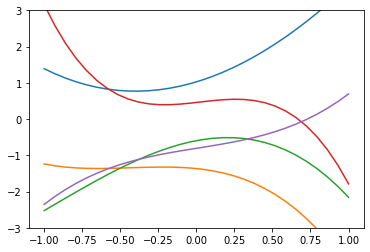

In [202]:
N = 30
x = np.linspace(-1, 1, N).reshape(-1,1)

for i in range(5):
    y = sample_from_prior(x)
    plt.plot(x,y)
plt.ylim(-3,3)
plt.show()
    

#### 事前分布だけを用いた予測分布の導出

場合によっては，学習を行う前に，事前分布だけを用いて何かしらの予測を行いたいこともあるかもしれない．

In [222]:
def predictive_distribution_using_prior(x, M=3, base_mode='polynomial', sigma_y=0.1):
    
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    H = (M+1)*D
    
    # 事前分布のパラメータを設定
    mu_0 = np.zeros(H)
    Sigma_0 = np.identity(H)
    
    # 特徴量関数を計算
    if(base_mode == 'polynomial'):
        phi = base_polynomial(x, 3)
    
    mu = np.einsum('h,nh->n', mu_0, phi)
    sigma = sigma_y + np.einsum('nh,hh,nh->n',phi,Sigma_0,phi)
    
    return mu,sigma

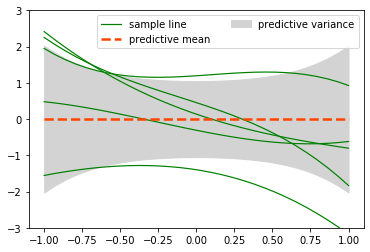

In [275]:
N = 30
x = np.linspace(-1, 1, N).reshape(-1,1)

for i in range(5):
    y = sample_from_prior(x)
    if i==0:
        plt.plot(x,y, color='green', linewidth = 1.2, label='sample line')
    else:
        plt.plot(x,y, color='green', linewidth = 1.2)
    
pred_mean, pred_var = predictive_distribution_using_prior(x)
upper = pred_mean + np.sqrt(pred_var)
lower = pred_mean - np.sqrt(pred_var)


plt.plot(x, pred_mean,color='orangered', linewidth = 2.5, linestyle='dashed', label='predictive mean')
plt.fill_between(x[:,0], upper, lower, color='lightgrey', label='predictive variance')
plt.legend(ncol=2)
plt.ylim(-3,3)
plt.show()

見てわかる通り，事前分布で仮定した構造（平均ゼロ，分散1）に基づき予測分布を導出できていることが分かる．
このように，ベイズ推論の枠組みではデータを学習していない段階でも何かしらの予測を行うことができる．
例えば，事前分布に対してもう少し具体的な事前情報（）を与えることで，その事前情報を最大限に利用した予測が可能である．

#### 学習と予測

実際に，データを学習させて予測を実装してみる．

In [975]:
def get_posterior_distribution(x, y, mu_0, Sigma_0, M=3, base_mode='polynomial', sigma_y=1):
    
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    H = (M+1)*D
    
    # 特徴量関数を計算
    if(base_mode == 'polynomial'):
        phi = base_polynomial(x, 3)
    
    Sigma = np.linalg.inv((sigma_y**(-1))*np.dot(phi.T, phi) + np.linalg.inv(Sigma_0))
    mu = np.dot(Sigma, sigma_y**(-1)*np.sum(y*phi, axis=0))
    
    return mu, Sigma

In [976]:
def sample_from_posterior(x, mu, Sigma, M=3, base_mode='polynomial', sigma_y=1):
    
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    H = (M+1)*D
    
    # -- 事前分布から重みをサンプルする． --
    w = np.random.multivariate_normal(mean=mu, cov=Sigma)
    
    # 特徴量関数を計算
    if(base_mode == 'polynomial'):
        phi = base_polynomial(x, 3)
        
    # -- 事前分布からサンプリング --
    model_mean = np.einsum('h,nh->n', w, phi)
    
    return model_mean

In [977]:
def predictive_distribution(x, mu, Sigma, M=3, base_mode='polynomial', sigma_y=1):
    
    N = x.shape[0] # サンプル数
    D = x.shape[1] # 入力次元
    H = (M+1)*D
    
    # 特徴量関数を計算
    if(base_mode == 'polynomial'):
        phi = base_polynomial(x, 3)
    
    mu_pred = np.dot(mu, phi.T)
    sigma_pred = sigma_y + np.diag(np.dot(phi.dot(Sigma), phi.T))
    
    return mu_pred,sigma_pred

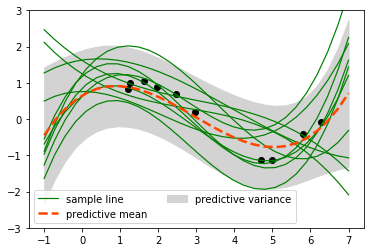

In [979]:
# 学習データ生成
#x_train = np.linspace(0, 6, 10).reshape(-1,1)
N_train = 10
x_train = 2*np.pi*np.random.rand(N_train).reshape(-1,1)
loc = 0
scale = 0.1
#y_train =  np.sin(2*np.pi*x_train) + np.random.normal(loc,scale,10).reshape(-1,1)
y_train =  np.sin(x_train) + np.random.normal(loc,scale,N_train).reshape(-1,1)

N = x_train.shape[0] # サンプル数
D = x_train.shape[1] # 入力次元
M = 3
H = (M+1)*D

mu_0 = np.zeros(H)
Sigma_0 = np.identity(H)

post_mu, post_Sigma = get_posterior_distribution(x_train, y_train, mu_0, Sigma_0, M)

x_pred = np.linspace(-1, 7, 30).reshape(-1,1)
    
pred_mean, pred_var = predictive_distribution(x_pred, post_mu, post_Sigma)
upper = pred_mean + np.sqrt(pred_var)
lower = pred_mean - np.sqrt(pred_var)

for i in range(10):
    y_sample = sample_from_posterior(x_pred, post_mu, post_Sigma)
    if i==0:
        plt.plot(x_pred, y_sample, color='green', linewidth = 1.2, label='sample line')
    else:
        plt.plot(x_pred, y_sample, color='green', linewidth = 1.2)

plt.plot(x_pred, pred_mean, color='orangered', linewidth = 2.5, linestyle='dashed', label='predictive mean')
plt.fill_between(x_pred[:,0], upper, lower, color='lightgrey', label='predictive variance')
plt.scatter(x_train, y_train, color='black', marker='o')

plt.legend(ncol=2)
plt.ylim(-3,3)
plt.show()

以上を踏まえ，ベイズ線形回帰クラスを作ってみる．

#### ベイズ線形回帰クラス

In [2]:
class BayesianLinearRegression:
    """Bayesian linear regression class"""
    def __init__(self):
        """Self variables
        
        self.mu_0 (Dx1 column vector): Mean vector
        self.Sigma_0 (DxD matrix): Covariance matrix
        self.sigma2_y: Noise term
        """
        self.mu_0 = None
        self.Sigma_0 = None
        self.sigma2_y = None
        
    def set_prior(self, mu_0, Sigma_0, sigma2_y):
        """Set parameters for prior distribution
        """
        self.mu_0 = mu_0 if mu_0.shape[0] == 1 else mu_0.T
        self.Sigma_0 = Sigma_0
        self.sigma2_y = sigma2_y
        
    def learn(self, x_train, y_train, M):
        """Learn model and update posterior distribution
        """
        phi_ = self.base_polynomial(x_train, M).T
        
        Sigma_ = np.linalg.inv((self.sigma2_y**(-1))*np.dot(phi_, phi_.T) \
                               + np.linalg.inv(self.Sigma_0))
        mu_ = np.dot(Sigma_, self.sigma2_y**(-1)*np.sum(y_train*phi_.T, axis=0) \
                     + np.dot(np.linalg.inv(self.Sigma_0), self.mu_0))
        
        self.mu_0 = mu_
        self.Sigma_0 = Sigma_
        
        return mu_, Sigma_
        
    def get_sample_from_posterior(self, x_lin):
        """Get sample from posterior distiburion
        """
        w_ = np.random.multivariate_normal(mean=self.mu_0, cov=self.Sigma_0)
        
        phi_ = self.base_polynomial(x_lin, M).T
        sample_mean_ = np.einsum('h,hn->n', w_, phi_)
        
        return sample_mean_
        
    def predict(self, x_test):
        """Calculate predictive distribution
        """
        phi_ = self.base_polynomial(x_test, M).T
        
        y_est_ = np.dot(self.mu_0.T, phi_)
        sigma2_y_est_ = self.sigma2_y + np.diag(np.dot(phi_.T.dot(self.Sigma_0), phi_))
        
        return y_est_, sigma2_y_est_
    
    def base_polynomial(self, x, M):
        """Calculate polynomial basis function
        """
        D_ = x.shape[1]
        phi_ = np.zeros(shape=(N_, int((M+1)*D_)), dtype='float')
        for m in range(M+1):
            phi_[:,m::(M+1)] = x**m
        return phi_

学習データを生成する．

In [32]:
N_train = 10 # number of samples
x_train = 2*np.pi*np.random.rand(N_train).reshape(-1,1)
y_train =  np.sin(x_train) + np.random.normal(0,0.1,N_train).reshape(-1,1)

D = x_train.shape[1] # number of dimensions
M = 3 # degree of polynimial
H = (M+1)*D # number of dimensions after transformation 

事前分布を設定し，事前分布からのサンプルを見てみる．

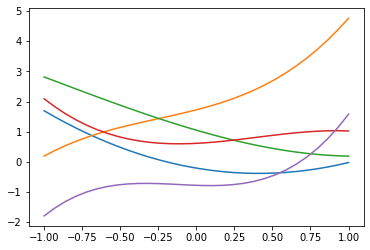

In [46]:
# Parameters for prior distribution
mu_0 = np.zeros(H)
Sigma_0 = np.identity(H)

BayesLR = BayesianLinearRegression()
BayesLR.set_prior(mu_0, Sigma_0, 1) # Set parameters

x_lin = np.linspace(-1, 1, 30).reshape(-1,1)

# Get five samples from prior
for i in range(5):
    y_sample = BayesLR.get_sample_from_posterior(x_lin)
    plt.plot(x_lin, y_sample)
    
plt.savefig("./image/3_bayesian_linear_regression_sample_from_prior.png",dpi=200)

学習データを用いて事後分布を計算し，そこから予測分布の平均と分散を可視化してみる

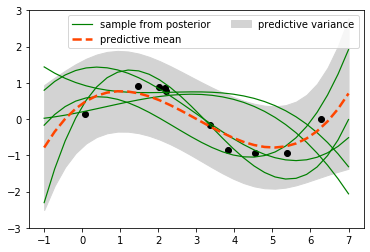

In [47]:
# Calculate posterior distribution
post_mu, post_Sigma = BayesLR.learn(x_train, y_train, M)

x_lin = np.linspace(-1, 7, 30).reshape(-1,1)

# Calculate predictive distribution
pred_mean, pred_var = BayesLR.predict(x_lin)

upper = pred_mean + np.sqrt(pred_var)
lower = pred_mean - np.sqrt(pred_var)

# Get five samples from posterior
for i in range(5):
    y_sample = BayesLR.get_sample_from_posterior(x_lin)
    if i==0:
        plt.plot(x_lin, y_sample, color='green', linewidth = 1.2, label='sample from posterior')
    else:
        plt.plot(x_lin, y_sample, color='green', linewidth = 1.2)

plt.plot(x_lin, pred_mean, color='orangered', linewidth = 2.5, linestyle='dashed', label='predictive mean')
plt.fill_between(x_lin[:,0], upper, lower, color='lightgrey', label='predictive variance')
plt.scatter(x_train, y_train, color='black', marker='o')

plt.legend(ncol=2)
plt.ylim(-3,3)
#plt.show()
plt.savefig("./image/3_bayesian_linear_regression_fitting.png",dpi=200)

一点ずつ学習させて，予測分布の挙動を見てみる．

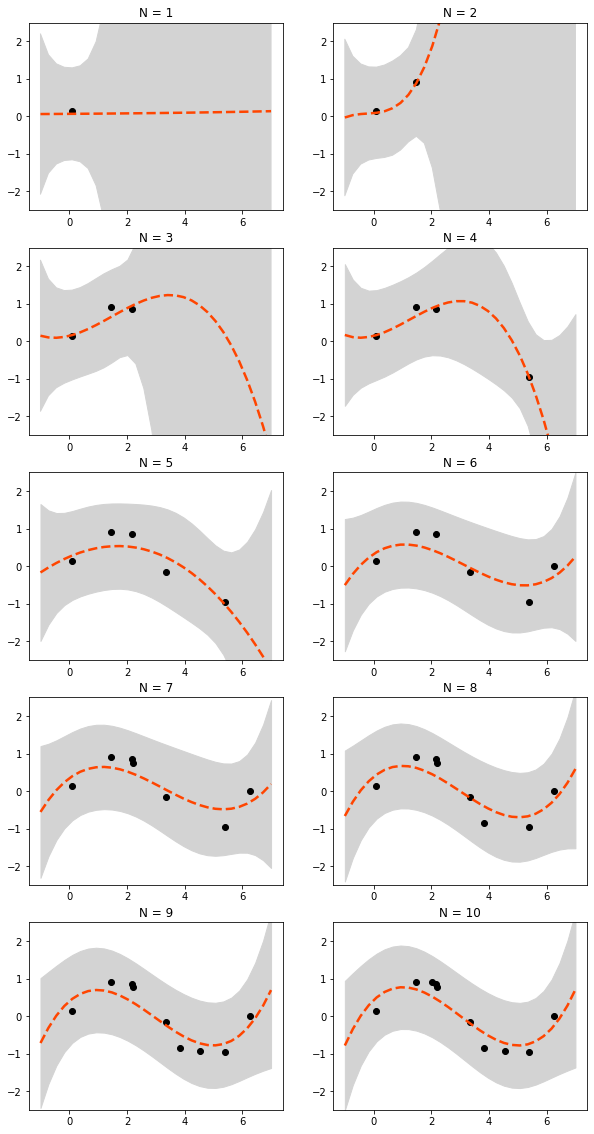

In [35]:
# Parameters for prior distribution
mu_0 = np.zeros(H)
Sigma_0 = np.identity(H)

x_lin = np.linspace(-1, 7, 30).reshape(-1,1)

BayesLR = BayesianLinearRegression()
BayesLR.set_prior(mu_0, Sigma_0, 1)

plt.figure(figsize=(10,20))

# Learn and predict one sample at a time
for i in range(N_train):
    # Calculate posterior
    BayesLR.learn(x_train[i].reshape(-1,1), y_train[i].reshape(-1,1), M)
    # Calculate predictive
    pred_mean, pred_var = BayesLR.predict(x_lin)
    upper = pred_mean + np.sqrt(pred_var)
    lower = pred_mean - np.sqrt(pred_var)
    
    plt.subplot(5,2,i+1)
    plt.plot(x_lin, pred_mean, color='orangered', linewidth = 2.5, linestyle='dashed', label='predictive mean')
    plt.fill_between(x_lin[:,0], upper, lower, color='lightgrey', label='predictive variance')
    plt.scatter(x_train[0:i+1], y_train[0:i+1], color='black', marker='o')
    plt.ylim(-2.5,2.5)
    plt.title('N = {}'.format(i+1))

plt.savefig("./image/3_bayesian_linear_regression_online_learning.png",dpi=200)

ちなみに，$N=10$の図を見て分かるように，このときの予測分布は全データを使って学習したときと一致している．
このように，共役事前分布を用いた場合は，データの生成過程に順序の依存性を仮定しない場合，データを逐次的に与えた場合と一度に全て与えた場合とで最終的に得られる事後分布は一致する．